<a href="https://colab.research.google.com/github/MRsources/MRzero-Core/blob/main/documentation/playground_mr0/unsorted/mr0_EPI_2D_with_ORC_seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pypulseq &> /dev/null
!pip install  torchkbnufft --no-deps
!pip install MRzeroCore --no-deps
!pip install pydisseqt

!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.9/406.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.5/470.5 kB 12.7 MB/s eta 0:00:00


(EPI_2D_seq)=
# 2D EPI

<ipython-input-2-c4a3280f6e35>:32: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf1, _, _ = pp.make_sinc_pulse(
/usr/local/lib/python3.11/dist-packages/MRzeroCore/util.py:515: UserWarning: write(): 64 timing errors found in the sequence
  seq.write('tmp.seq')


DEPRECATED: util.simulate_2d will be removed in the future.
Use util.simulate() instead (together with util.load_phantom() if necessary
Calculating repetition 1 / 1 - done


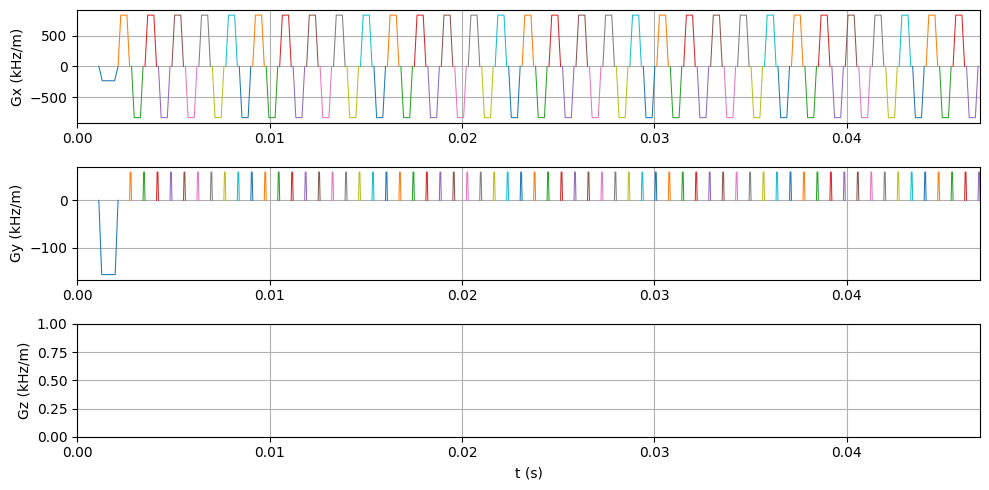

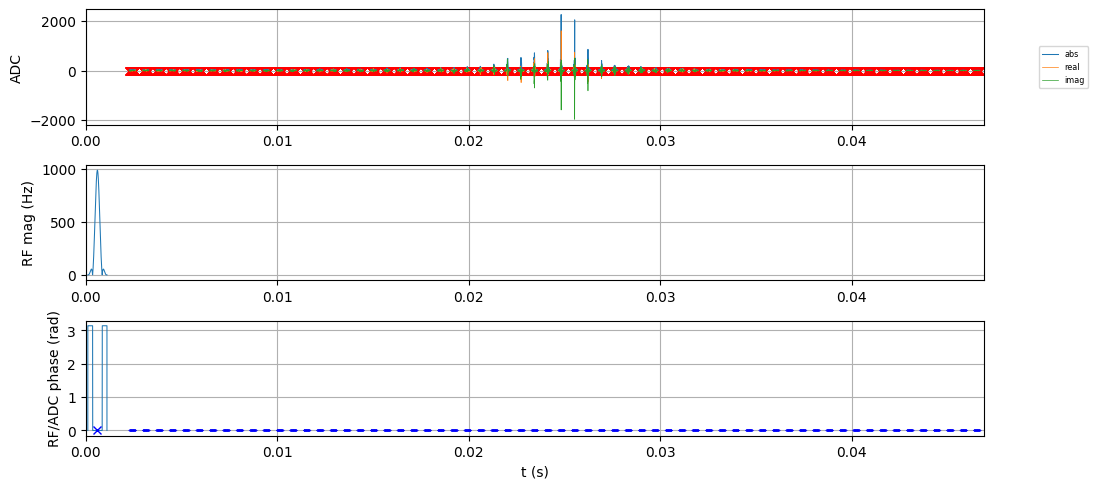

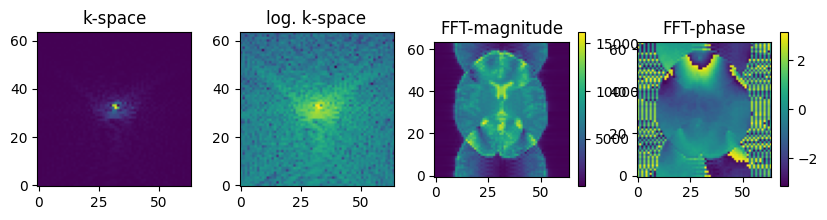

In [2]:
import numpy as np
import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exB09_GRE_EPI_2D'

# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6
)

# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 240e-3
slice_thickness = 8e-3
sz = (64, 64)   # spin system size / resolution
Nread = 64    # frequency encoding steps/samples
Nphase = 64    # phase encoding steps/samples

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)

# Define other gradients and ADC events
adc_duration_OG = 0.25e-3 # @param {type: "slider", min: 0.25e-3, max: 10e-3, step: 0.05e-3}
a = int(system.adc_raster_time * Nread * 10**7)
b = int(system.grad_raster_time * 10**7)
c = int(adc_duration_OG * 10**7)
lcm_ab = abs(a * b) // np.gcd(a, b)
adc_raster_duration = (lcm_ab if round(c / lcm_ab) == 0 else round(c / lcm_ab) * lcm_ab) / 10**7

eddy_currents=True # @param {type:"boolean"}
eddy_currents_induced_delay= 0.0000015 # @param {type: "slider", min: -1e-4, max: 1e-4, step: 1e-8}
eddy_currents_induced_delay*=eddy_currents

gx = pp.make_trapezoid(channel='x', flat_area=Nread / fov, flat_time=adc_raster_duration, system=system)
gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread / fov, flat_time=adc_raster_duration, system=system)
adc = pp.make_adc(num_samples=Nread, duration=adc_raster_duration, phase_offset=0 * np.pi / 180, delay=gx.rise_time + eddy_currents_induced_delay, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

# ======
# CONSTRUCT SEQUENCE
# ======
blip_duration=0.1e-3 # @param {type: "slider", min: 0.1e-3, max: 50e-3, step: 0.05e-3}
gp_blip = pp.make_trapezoid(channel='y', area=1 / fov, duration=blip_duration, system=system)

seq.add_block(rf1)
gp = pp.make_trapezoid(channel='y', area=-Nphase//2 / fov, duration=1e-3, system=system)
seq.add_block(gx_pre, gp)

for ii in range(0, Nphase//2):
    seq.add_block(gx,adc)
    seq.add_block(gp_blip)
    seq.add_block(gx_,adc)
    seq.add_block(gp_blip)

#quick 2D brain phantom sim and plot
signal = mr0.util.simulate_2d(seq)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure(figsize=(10,2))  # fig.clf()

kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:,0::2] = torch.flip(kspace[:,0::2],[0] )[:,:]
# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

In [3]:
# @title Export sequence as .seq file

# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq_write_signature = seq.write(experiment_id + '.seq')

Timing check failed. Error listing follows:
namespace(block=3, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')
namespace(block=5, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')
namespace(block=7, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')
namespace(block=9, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')
namespace(block=11, event='adc', field='delay', value=0.00014150000000000002, value_rounded=0.00014199999999999998, error=-4.999999999999579e-07, raster='rf_raster_time', error_type='RASTER')


<ipython-input-3-7fac4cefd44e>:14: UserWarning: write(): 64 timing errors found in the sequence
  seq_write_signature = seq.write(experiment_id + '.seq')


# Phantom changes

If you alter phantom parameters between

```
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
```
and
```
obj_p = obj_p.build()
```

you can alter the object manually to study phase images or distortions.

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


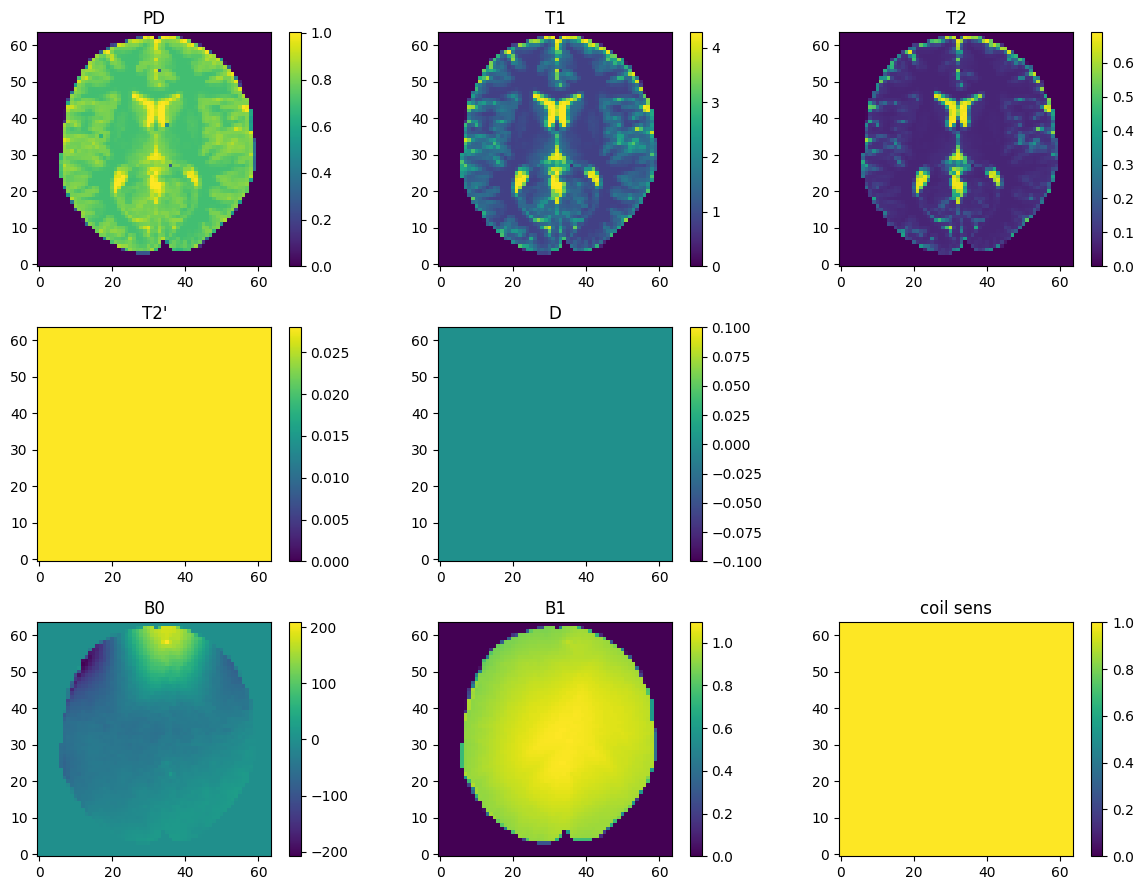

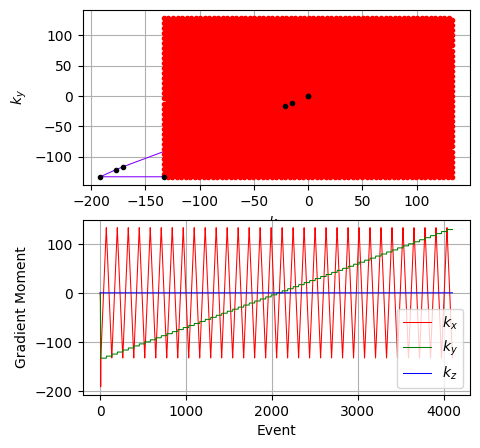

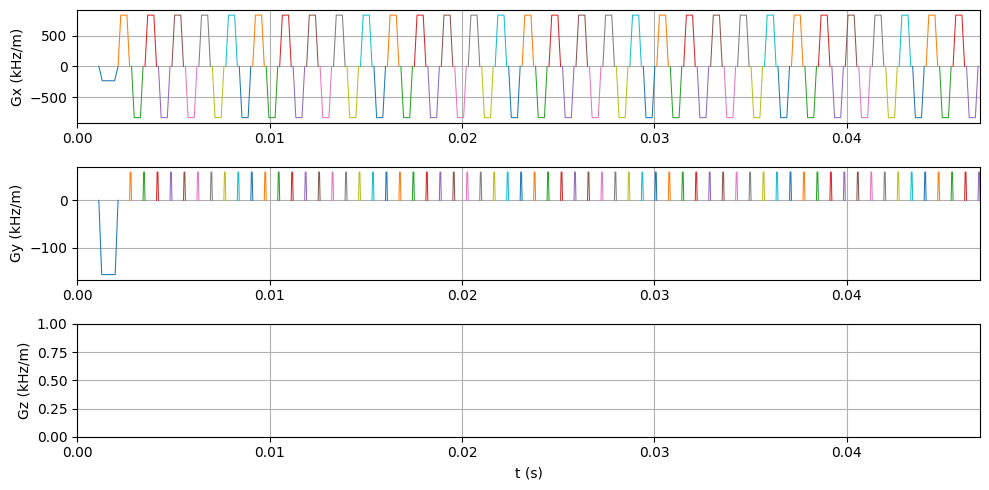

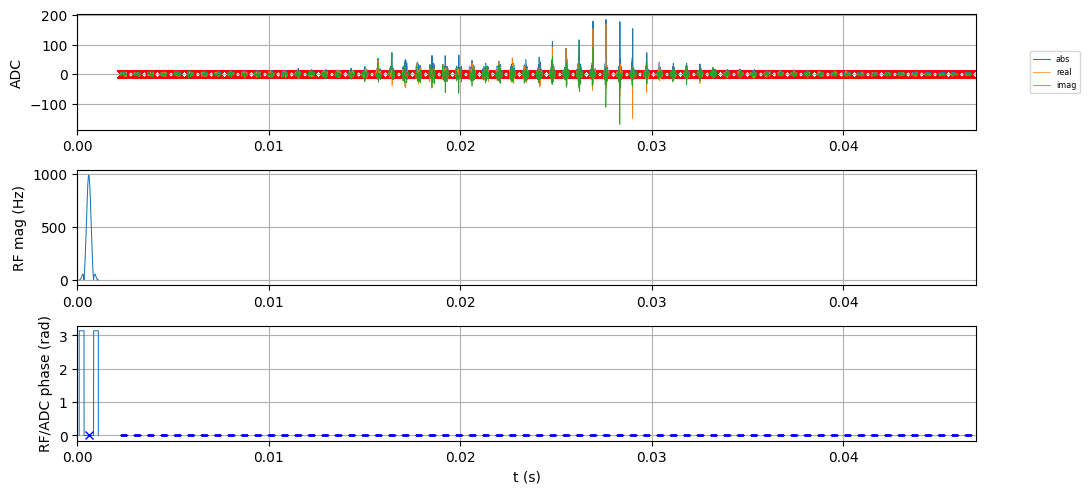

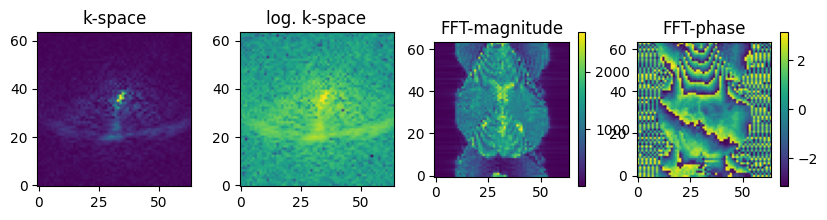

In [4]:
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]

# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.D *= 0
T2dash=0.028001# @param {type: "slider", min: 1e-6, max: 100e-3, step:1e-3}
obj_p.T2dash[:] =T2dash
B0factor=5# @param {type: "slider", min: -20, max: 20, step:1}
obj_p.B0 *= B0factor    # alter the B0 inhomogeneity

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure(figsize=(10,2))  # fig.clf()

kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
kspace = kspace_adc
kspace[:,0::2] = torch.flip(kspace[:,0::2],[0] )[:,:]
# fftshift FFT fftshift
spectrum = torch.fft.fftshift(kspace)
space = torch.fft.fft2(spectrum)
space = torch.fft.ifftshift(space)

plt.subplot(141)
plt.title('k-space')
mr0.util.imshow(np.abs(kspace.numpy()))
plt.subplot(142)
plt.title('log. k-space')
mr0.util.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(143)
plt.title('FFT-magnitude')
mr0.util.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(144)
plt.title('FFT-phase')
mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# Distortion correction using OCR mrinufft

In [8]:
!pip install mri-nufft
!pip install finufft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 6.8 MB/s eta 0:00:00


Object size: tensor([0.2000, 0.2000, 0.0080])
Performing Off-Resonance Correction (ORC)...
Trajectory shape: torch.Size([4096, 2])
Time points shape: torch.Size([4096])
Time range: 1.66 ms to 46.08 ms
k-space range x: -3.13 to 3.13
k-space range y: -3.14 to 3.04
Skipping density compensation (Cartesian-like sampling)


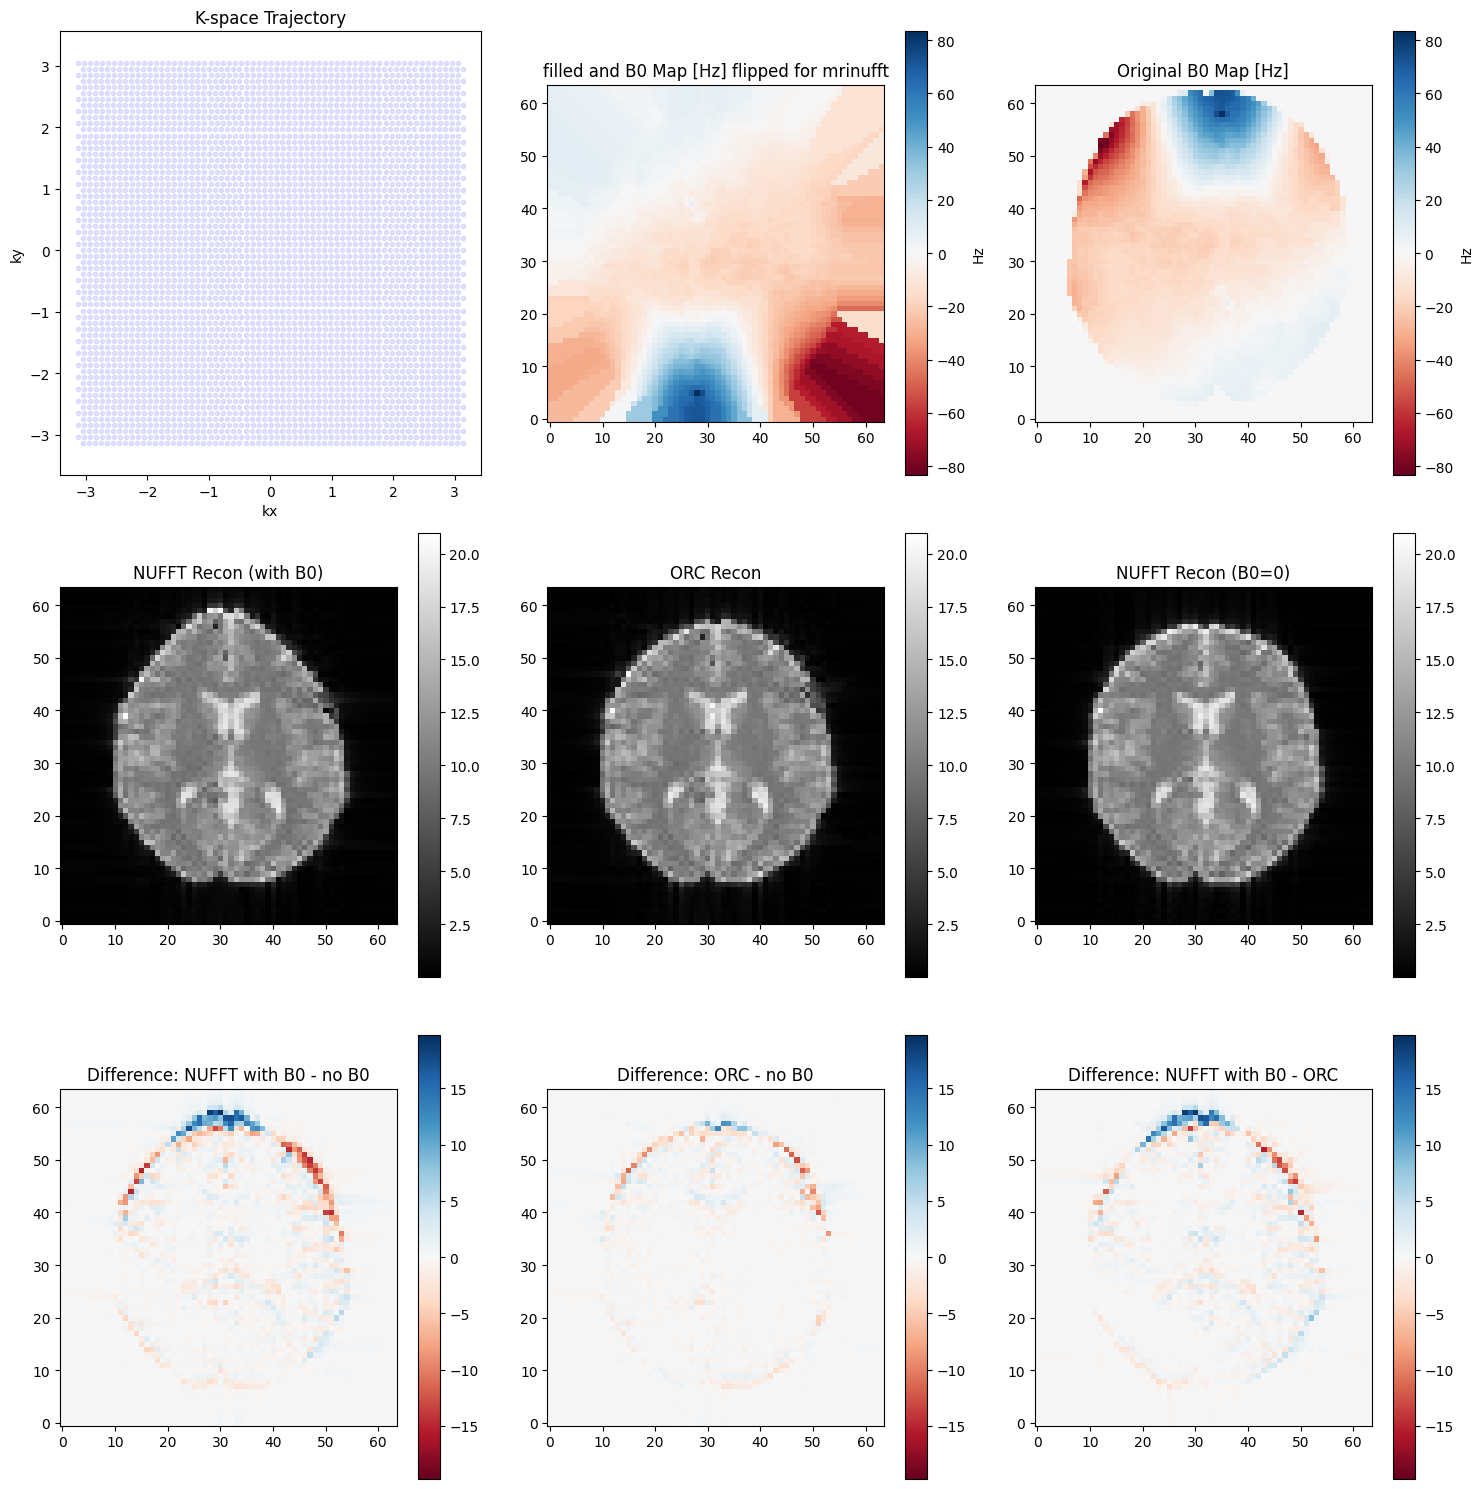

ADC duration per line: 0.25 ms
Total readout duration: 46.08 ms
Number of time points: 4096


In [11]:
import mrinufft
from scipy.interpolate import griddata
from scipy.ndimage import binary_erosion

verbose=0

# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]

# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.D *= 0
T2dash=0.028001
obj_p.T2dash[:] =T2dash
r2star=1/obj_p.T2dash+1/obj_p.T2
B0factor=2# @param {type: "slider", min: -20, max: 20, step:1}
obj_p.B0 *= B0factor    # alter the B0 inhomogeneity
B0_map_Hz = obj_p.B0 # save for later
PD = obj_p.PD # save for later
if verbose:
    obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()

print(f"Object size: {obj_p.size}")


# (i) load a phantom object from file
obj_p_0 = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p_0 = obj_p_0.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p_0.D *= 0
T2dash=0.028001
obj_p_0.T2dash[:] =T2dash
obj_p_0.T2*=1
B0factor=0    # alter the B0 inhomogeneity
obj_p_0.B0 *= B0factor    # alter the B0 inhomogeneity
#B0_map_Hz = obj_p_0.B0 # save for later
if verbose:
    obj_p_0.plot()
# Convert Phantom into simulation data
obj_p_0 = obj_p_0.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.import_file(experiment_id + '.seq')
if verbose:
    seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p, print_progress=False)

signal_0 = mr0.execute_graph(graph, seq0, obj_p_0, print_progress=False)
# PLOT sequence with signal in the ADC subplot
if verbose:
    plt.close(11);plt.close(12)
    seq.plot(plot_now=False)
    mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
    plt.show()

# %% S6: MR IMAGE RECON of signal ::: #####################################
if verbose:
    fig = plt.figure(figsize=(10,2))  # fig.clf()

    kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
    kspace = kspace_adc
    kspace[:,1::2] = torch.flip(kspace[:,1::2],[0] )[:,:]
    # fftshift FFT fftshift
    spectrum = torch.fft.fftshift(kspace)
    space = torch.fft.fft2(spectrum)
    space = torch.fft.ifftshift(space)

    plt.subplot(141)
    plt.title('k-space')
    mr0.util.imshow(np.abs(kspace.numpy()))
    plt.subplot(142)
    plt.title('log. k-space')
    mr0.util.imshow(np.log(np.abs(kspace.numpy())))

    plt.subplot(143)
    plt.title('FFT-magnitude')
    mr0.util.imshow(np.abs(space.numpy()))
    plt.colorbar()
    plt.subplot(144)
    plt.title('FFT-phase')
    mr0.util.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
    plt.colorbar()
    plt.show()

## now lets try to add off-resonance correction
print("Performing Off-Resonance Correction (ORC)...")

# Import required libraries for ORC
import mrinufft
from mrinufft.operators import MRIFourierCorrected
from mrinufft.density import voronoi
from mrinufft.trajectories.utils import DEFAULT_RASTER_TIME

# Configuration flags
use_density_compensation = False  # Set to False for Cartesian-like sampling

# Get trajectory directly from sequence
ktraj_and_time = seq0.get_kspace()
ktraj = ktraj_and_time[:,[0,1]]  # First two columns are kx, ky
t_read = ktraj_and_time[:,3]   # Fourth column is time

# Print trajectory info for debugging
print(f"Trajectory shape: {ktraj.shape}")
print(f"Time points shape: {t_read.shape}")
print(f"Time range: {t_read.min()*1e3:.2f} ms to {t_read.max()*1e3:.2f} ms")

# Convert trajectory to numpy and normalize for finufft
ktraj = ktraj.numpy() if torch.is_tensor(ktraj) else ktraj

# Scale k-space coordinates:
# 1. Multiply by FOV to convert from 1/m to cycles/FOV
# 2. Divide by matrix size to normalize to [-π,π] range
# 3. Multiply by 2π for finufft convention
ktraj = ktraj * fov  # Convert from 1/m to cycles/FOV
ktraj[:,0] = ktraj[:,0] * (2 * np.pi / Nread)  # Normalize kx
ktraj[:,1] = ktraj[:,1] * (2 * np.pi / Nphase)  # Normalize ky

print(f"k-space range x: {ktraj[:,0].min():.2f} to {ktraj[:,0].max():.2f}")
print(f"k-space range y: {ktraj[:,1].min():.2f} to {ktraj[:,1].max():.2f}")

# Calculate density compensation only if needed
if use_density_compensation:
    density = voronoi(ktraj)  # No need for .T since shape is already correct
    print("Using Voronoi density compensation")
else:
    density = None
    print("Skipping density compensation (Cartesian-like sampling)")

# Create the NUFFT operator with proper normalization
nufft = mrinufft.get_operator("finufft")(
    samples=ktraj,  # Already in correct shape
    shape=(sz[0], sz[1]),
    density=density,
)

# Ensure B0 map is properly scaled and in Hz
B0_map_2D = B0_map_Hz[:,:,0].numpy()  # Extract 2D slice
B0_map_2D = np.flipud(B0_map_2D)
B0_map_2D = np.fliplr(B0_map_2D)

# Create mask for brain region and erode it by one pixel
brain_mask = np.abs(B0_map_2D) > 0
eroded_mask = binary_erosion(brain_mask, iterations=1)

# Apply eroded mask to B0 map
B0_map_2D_eroded = B0_map_2D * eroded_mask

# Get coordinates of all points and points with defined B0 values
y, x = np.mgrid[0:B0_map_2D.shape[0], 0:B0_map_2D.shape[1]]
points_with_values = np.column_stack((y[eroded_mask], x[eroded_mask]))
values = B0_map_2D_eroded[eroded_mask]

# Create grid for interpolation
grid_y, grid_x = np.mgrid[0:B0_map_2D.shape[0], 0:B0_map_2D.shape[1]]

# Perform nearest neighbor interpolation
B0_map_2D_filled = griddata(points_with_values, values, (grid_y, grid_x), method='nearest')

# Use the interpolated B0 map for reconstruction
r2star_map = np.flipud(r2star[:,:,0].numpy())
r2star_map = np.fliplr(r2star_map)
r2star_map[np.isnan(r2star_map)] = 0
r2star_map[np.isinf(r2star_map)] = 0

if 0:
    mask = np.abs(PD[:,:,0]) > 0  # Create mask from PD map
else:
    mask = np.ones_like(PD[:,:,0])

# Create the ORC NUFFT operator
orc_nufft = MRIFourierCorrected(
    nufft,
    b0_map=-B0_map_2D_filled,  # Use interpolated B0 map
    readout_time=t_read,
    n_time_segments=12,
    mask=mask
)

# Create the ORC NUFFT operator with T2* correction, this doesnt work yet and is not used or displayed below.
orc_r2c_nufft = MRIFourierCorrected(
    nufft,
    b0_map=-B0_map_2D_filled,  # Use interpolated B0 map
    r2star_map=-r2star_map/(2*np.pi),
    readout_time=t_read,
    n_time_segments=8,
    mask=mask
)

# Reshape signals for reconstruction
signal_flat = signal.numpy().flatten()
signal_flat_0 = signal_0.numpy().flatten()

# Perform ORC reconstruction
recon_nufft = nufft.adj_op(signal_flat)     # distorted image
recon_nufft_0 = nufft.adj_op(signal_flat_0) # undistorted image
recon_orc = orc_nufft.adj_op(signal_flat)   # ORC distortion corrected image

mask = np.fliplr(mask)
recon_nufft = np.fliplr(recon_nufft)
recon_nufft_0 = np.fliplr(recon_nufft_0)
recon_orc = np.fliplr(recon_orc)

# Calculate all visualization limits
# Magnitude scale based on NUFFT reconstruction
vmin_mag = np.abs(recon_nufft)[mask > 0].min()
vmax_mag = np.abs(recon_nufft)[mask > 0].max()

# Symmetric limits for B0 maps
b0_max = np.max(np.abs(B0_map_2D_filled * mask))
b0_lims = [-b0_max, b0_max]

# Symmetric limits for difference maps
diff_data = [
    (np.abs(recon_nufft) - np.abs(recon_nufft_0)) * mask,  # NUFFT with B0 - no B0
    (np.abs(recon_orc) - np.abs(recon_nufft_0)) * mask,    # ORC - no B0
    (np.abs(recon_nufft) - np.abs(recon_orc)) * mask       # NUFFT with B0 - ORC
]
diff_max = np.max([np.abs(d[mask > 0]).max() for d in diff_data])
diff_lims = [-diff_max, diff_max]

# Plot diagnostics
plt.figure(figsize=(15, 15))  # Made figure taller to accommodate new row

plt.subplot(331)
plt.title('K-space Trajectory')
plt.plot(ktraj[:,0], ktraj[:,1], 'b.', alpha=0.1)
plt.axis('equal')
plt.xlabel('kx')
plt.ylabel('ky')

plt.subplot(332)
plt.title('filled and B0 Map [Hz] flipped for mrinufft')
mr0.util.imshow(B0_map_2D_filled * mask, cmap='RdBu', vmin=b0_lims[0], vmax=b0_lims[1])
plt.colorbar(label='Hz')

plt.subplot(333)
plt.title('Original B0 Map [Hz]')
mr0.util.imshow(B0_map_Hz[:,:,0].numpy() * mask, cmap='RdBu', vmin=b0_lims[0], vmax=b0_lims[1])
plt.colorbar(label='Hz')

plt.subplot(334)
plt.title('NUFFT Recon (with B0)')
mr0.util.imshow(np.abs(recon_nufft) * mask, cmap='gray', vmin=vmin_mag, vmax=vmax_mag)
plt.colorbar()

plt.subplot(335)
plt.title('ORC Recon')
mr0.util.imshow(np.abs(recon_orc) * mask, cmap='gray', vmin=vmin_mag, vmax=vmax_mag)
plt.colorbar()

plt.subplot(336)
plt.title('NUFFT Recon (B0=0)')
mr0.util.imshow(np.abs(recon_nufft_0) * mask, cmap='gray', vmin=vmin_mag, vmax=vmax_mag)
plt.colorbar()

plt.subplot(337)
plt.title('Difference: NUFFT with B0 - no B0')
mr0.util.imshow(diff_data[0], cmap='RdBu', vmin=diff_lims[0], vmax=diff_lims[1])
plt.colorbar()

plt.subplot(338)
plt.title('Difference: ORC - no B0')
mr0.util.imshow(diff_data[1], cmap='RdBu', vmin=diff_lims[0], vmax=diff_lims[1])
plt.colorbar()

plt.subplot(339)
plt.title('Difference: NUFFT with B0 - ORC')
mr0.util.imshow(diff_data[2], cmap='RdBu', vmin=diff_lims[0], vmax=diff_lims[1])
plt.colorbar()

plt.tight_layout()
plt.show()

# Print timing information
print(f"ADC duration per line: {adc_duration_OG*1e3:.2f} ms")
print(f"Total readout duration: {t_read[-1]*1e3:.2f} ms")
print(f"Number of time points: {len(t_read)}")